In [1]:
%load_ext autoreload
%autoreload 2

Import required Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys

Ignoring Warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

Import modules

In [4]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot
from logger import Logger

In [5]:
# Initialize logger
logger = Logger("userEngagement.log").get_app_logger()
logger.info("Initialized user_experience logger")

import data

In [6]:
#reading the cleaned data in EDA
df_org = pd.read_csv("C:\\Users\\1221\\Desktop\\Telecommunication-Data\\data\\cleaned telecom data.csv")

In [7]:
df = df_org.copy()

In [8]:
pl = Plot()
overview = Overview(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148027 entries, 0 to 148026
Data columns (total 57 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 148027 non-null  float64
 1   Start                                     148027 non-null  object 
 2   Start ms                                  148027 non-null  float64
 3   End                                       148027 non-null  object 
 4   End ms                                    148027 non-null  float64
 5   IMSI                                      148027 non-null  float64
 6   MSISDN/Number                             148027 non-null  float64
 7   IMEI                                      148027 non-null  float64
 8   Last Location Name                        148027 non-null  object 
 9   Avg RTT DL (ms)                           148027 non-null  float64
 10  Avg RTT UL (ms)     

<Axes: ylabel='Avg RTT DL (ms)'>

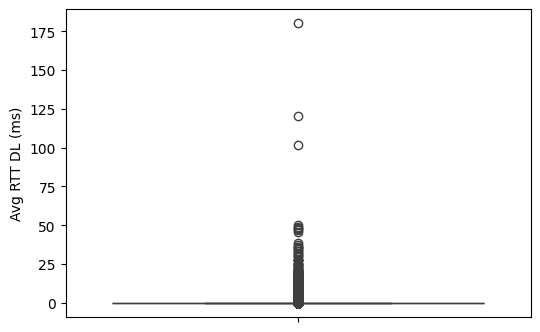

In [10]:
plt.figure(figsize=(6, 4))
sns.boxplot(df['Avg RTT DL (ms)'], orient='vert')

Aggregate, per customer - Average TCP retransmission - Average RTT - Handset type - Average throughput

In [11]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'TCP DL Retrans. Vol (Bytes)',
       'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)',
       '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)',
       'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)',
       '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)',
       'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)',
       'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type',
       'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',
       'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B',
       'Social Media DL (Bytes)', 'Social Media UL (Bytes)'

Get the total transimissions for each customer

In [12]:
user_experience = df[[
    "MSISDN/Number",
    "Avg RTT DL (ms)",
    "Avg RTT UL (ms)",
    "Avg Bearer TP UL (Bytes/s)",
    "Avg Bearer TP DL (Bytes/s)",
    "TCP DL Retrans. Vol (Bytes)",
    "TCP UL Retrans. Vol (Bytes)",
    "Handset Type"]]

user_experience['avg_rtt_total'] = user_experience['Avg RTT DL (ms)'] + user_experience['Avg RTT UL (ms)']
user_experience['avg_bearer_tp_total'] = user_experience['Avg Bearer TP UL (Bytes/s)'] + user_experience['Avg Bearer TP DL (Bytes/s)']
user_experience['avg_tcp_retrans_total'] = user_experience['TCP DL Retrans. Vol (Bytes)'] + user_experience['TCP UL Retrans. Vol (Bytes)']

In [13]:
user_experience.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP UL (Bytes/s),Avg Bearer TP DL (Bytes/s),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Handset Type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,-0.002510,-0.135939,-1.645883e-01,-0.373847,-0.556274,0.000000,0.000000,Apple iPhone 7 (A1778),-3.005272e-01,-0.930121,0.000000
1,-0.002509,0.000000,4.613194e-17,-0.382889,-0.557894,0.000000,0.000000,Samsung Galaxy J5 (Sm-J530),4.613194e-17,-0.940783,0.000000
2,-0.002636,-0.039100,1.720148e-02,1.448078,0.586901,-0.079805,0.026181,Huawei B528S-23A,-2.189841e-02,2.034979,-0.053624
3,-0.002506,-0.072621,7.313758e-01,0.193850,0.194945,-0.174039,-0.008035,Huawei B528S-23A,6.587547e-01,0.388794,-0.182074
4,-0.002624,0.000000,4.613194e-17,-0.375354,-0.557188,0.000000,0.000000,Samsung Galaxy S8 (Sm-G950F),4.613194e-17,-0.932542,0.000000


In [14]:
user_experience_agg = user_experience.groupby('MSISDN/Number').agg({
    'avg_rtt_total': 'sum',
    'avg_bearer_tp_total': 'sum',
    'avg_tcp_retrans_total': 'sum',
    'Handset Type': [lambda x: x.mode()[0]]})

user_experience_df = pd.DataFrame()

user_experience_df["avg_rtt_total"] = user_experience_agg["avg_rtt_total"]['sum']
user_experience_df["avg_tp_total"] = user_experience_agg["avg_bearer_tp_total"]['sum']
user_experience_df["total_avg_tcp_total"] = user_experience_agg["avg_tcp_retrans_total"]['sum']
user_experience_df["Handset Type"] = user_experience_agg["Handset Type"]['<lambda>']
user_experience_df.head()

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,Handset Type
MSISDN/Number,,,,
-0.002692,-3.449670e-01,-0.933036,0.000000,Huawei P20 Lite Huawei Nova 3E
-0.002692,-3.617786e-01,-0.929996,0.000000,Apple iPhone 7 (A1778)
-0.002692,4.613194e-17,-0.930427,0.000000,undefined
-0.002692,-1.073595e-01,-0.925022,-0.177368,Apple iPhone 5S (A1457)
-0.002692,-5.840387e-01,3.333343,-0.144598,Apple iPhone Se (A1723)


Compute & list 10 of the top, bottom and most frequent:

In [15]:
user_experience.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP UL (Bytes/s),Avg Bearer TP DL (Bytes/s),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Handset Type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,-0.002510,-0.135939,-1.645883e-01,-0.373847,-0.556274,0.000000,0.000000,Apple iPhone 7 (A1778),-3.005272e-01,-0.930121,0.000000
1,-0.002509,0.000000,4.613194e-17,-0.382889,-0.557894,0.000000,0.000000,Samsung Galaxy J5 (Sm-J530),4.613194e-17,-0.940783,0.000000
2,-0.002636,-0.039100,1.720148e-02,1.448078,0.586901,-0.079805,0.026181,Huawei B528S-23A,-2.189841e-02,2.034979,-0.053624
3,-0.002506,-0.072621,7.313758e-01,0.193850,0.194945,-0.174039,-0.008035,Huawei B528S-23A,6.587547e-01,0.388794,-0.182074
4,-0.002624,0.000000,4.613194e-17,-0.375354,-0.557188,0.000000,0.000000,Samsung Galaxy S8 (Sm-G950F),4.613194e-17,-0.932542,0.000000


In [16]:
top_10_tcp = user_experience.nlargest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
bottom_10_tcp = user_experience.nsmallest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
most_frequent_tcp = user_experience.value_counts('avg_bearer_tp_total').nlargest(10)

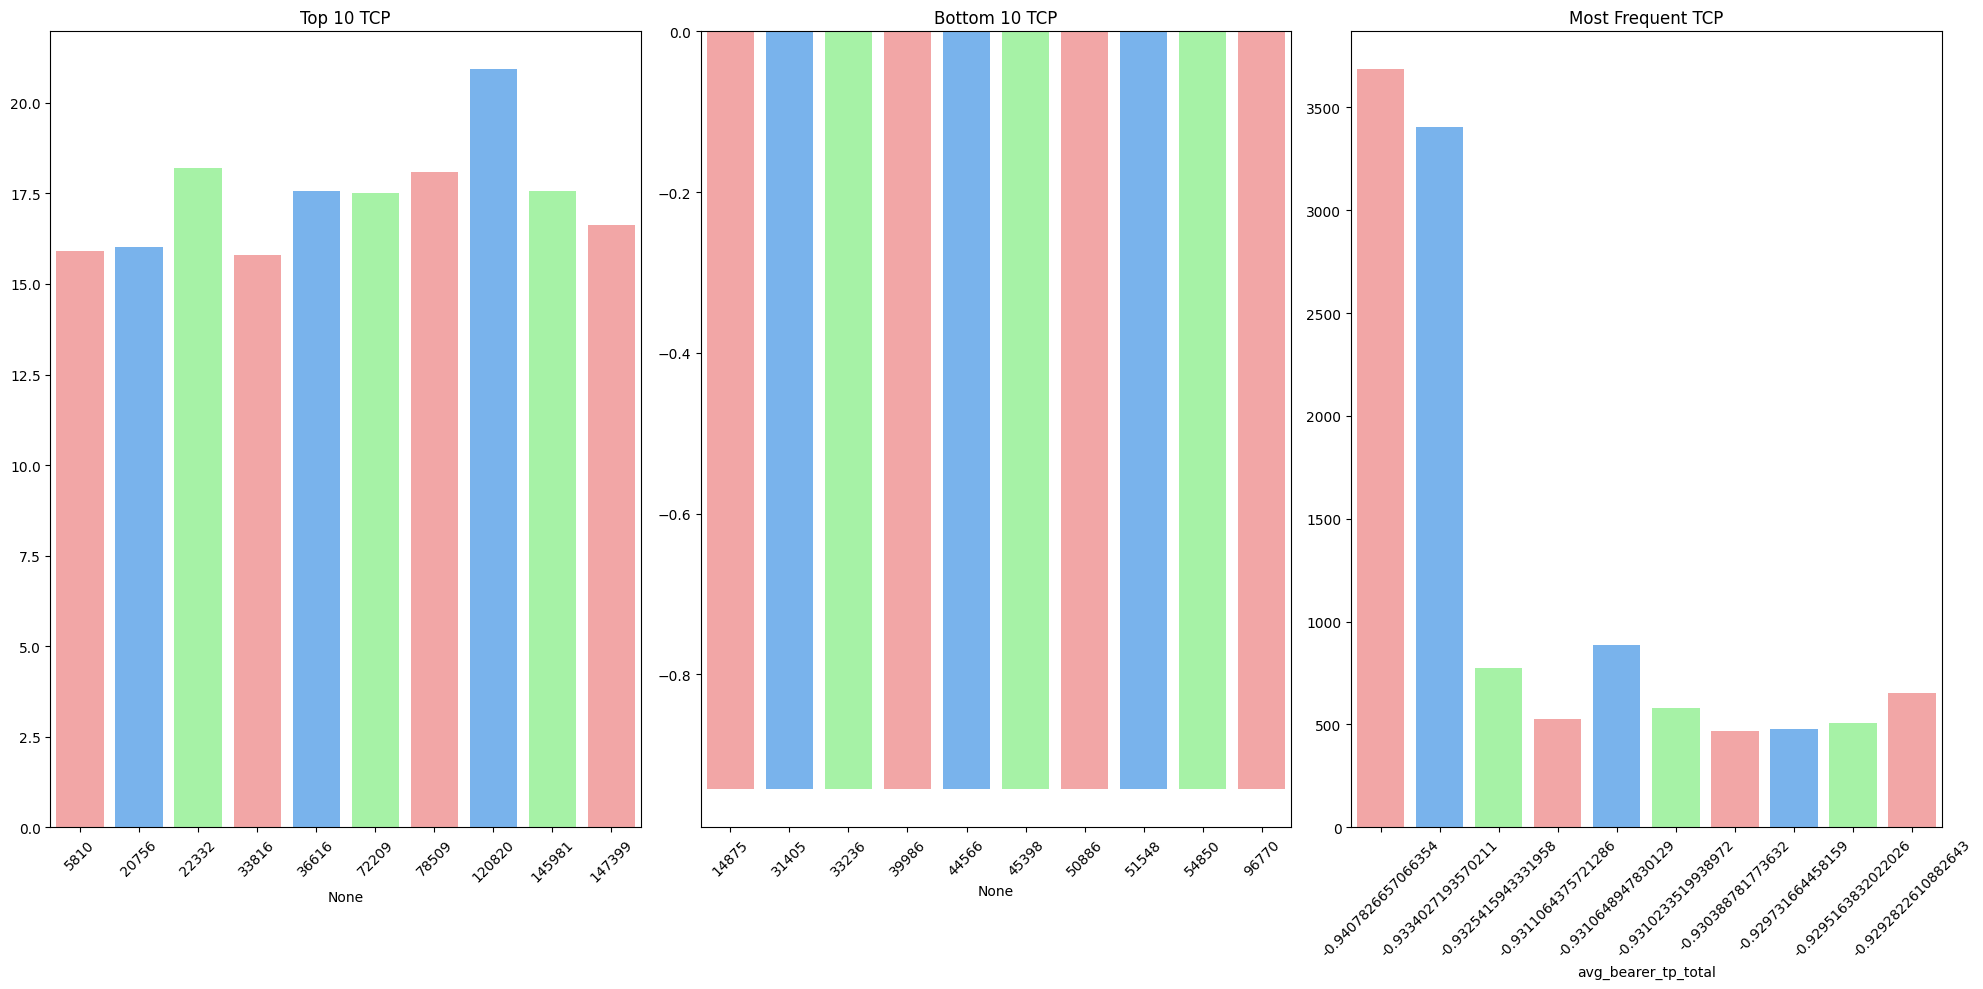

In [17]:
# Custom palette with specific colors
custom_palette = ['#ff9999', '#66b3ff', '#99ff99']

# Create a figure with 3 subplots
f, axes = plt.subplots(1, 3, figsize=(20, 10))

# First bar plot for top_10_tcp
ax1 = sns.barplot(x=top_10_tcp.index, y=top_10_tcp.values, ax=axes[0], palette=custom_palette)
ax1.set_title("Top 10 TCP")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Second bar plot for bottom_10_tcp
ax2 = sns.barplot(x=bottom_10_tcp.index, y=bottom_10_tcp.values, ax=axes[1], palette=custom_palette)
ax2.set_title("Bottom 10 TCP")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Third bar plot for most_frequent_tcp
ax3 = sns.barplot(x=most_frequent_tcp.index, y=most_frequent_tcp.values, ax=axes[2], palette=custom_palette)
ax3.set_title("Most Frequent TCP")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

RTT VALUES

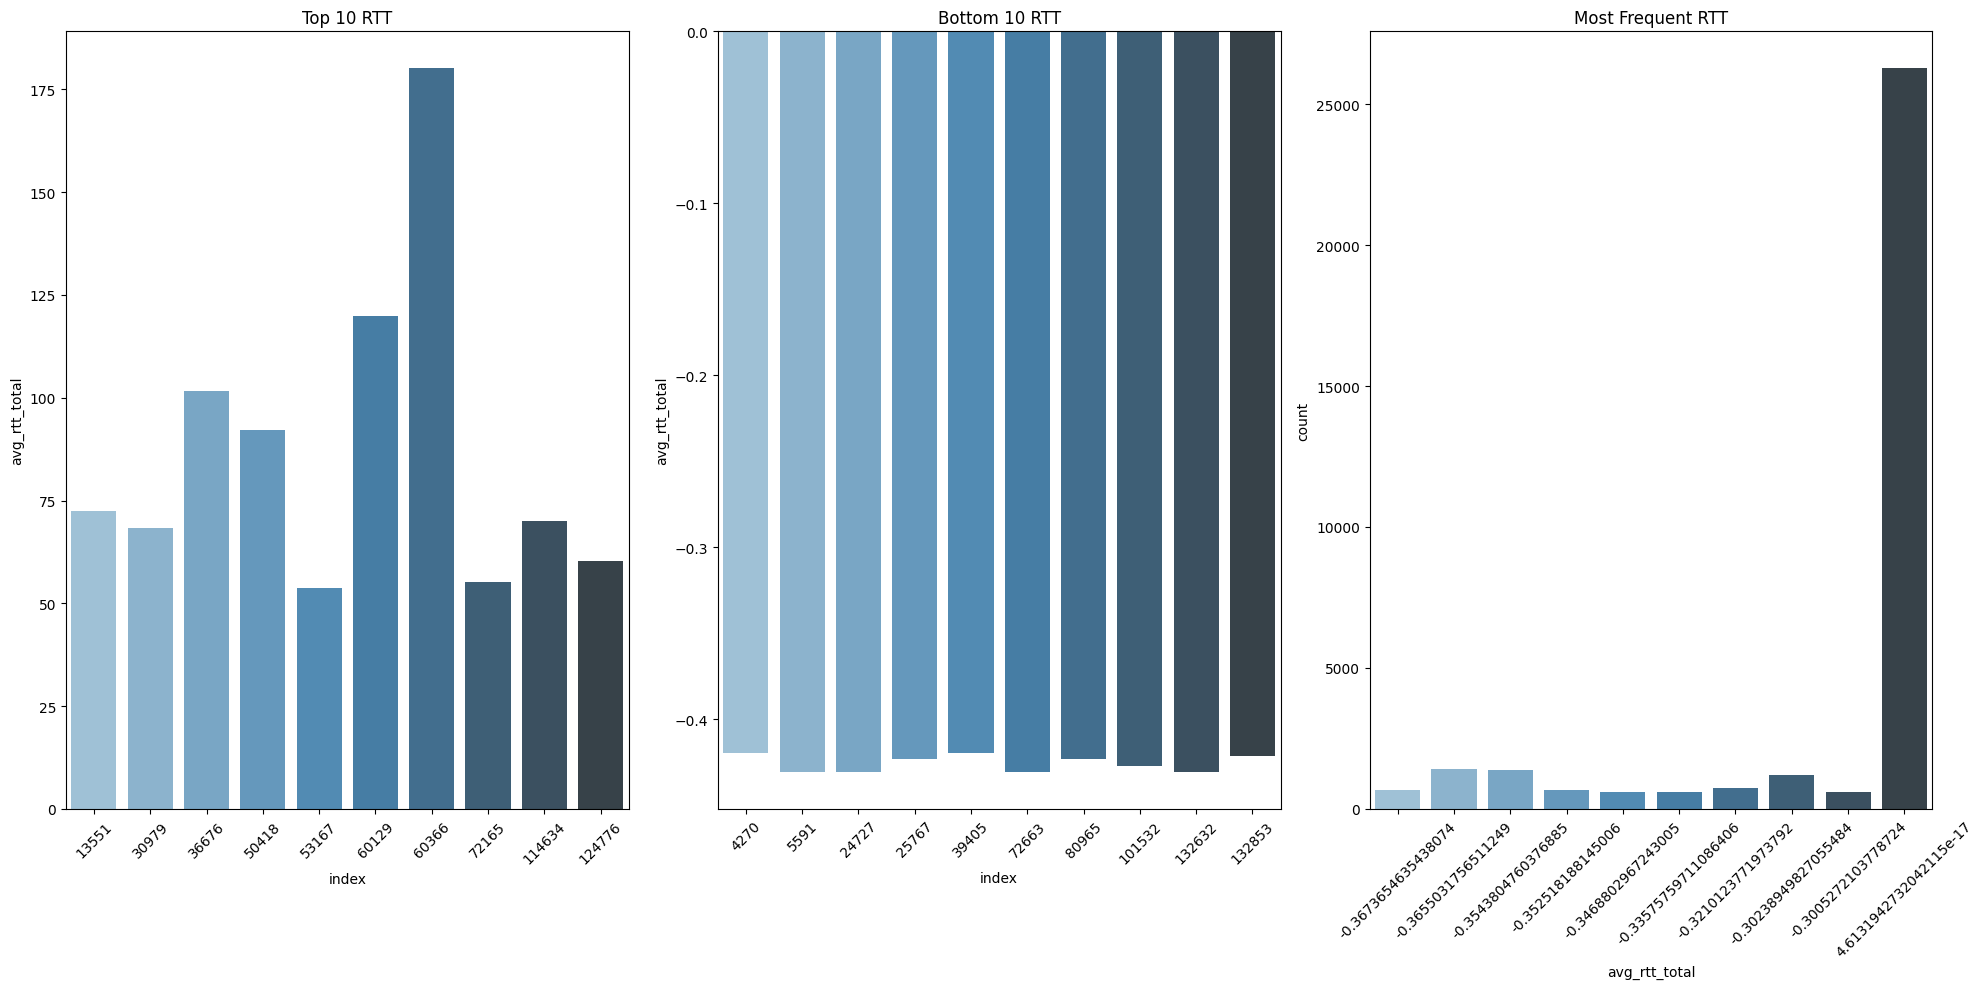

In [18]:
# Extract the top, bottom, and most frequent RTT values
top_10_rtt = user_experience.nlargest(10, 'avg_rtt_total')[['avg_rtt_total']].reset_index()
bottom_10_rtt = user_experience.nsmallest(10, 'avg_rtt_total')[['avg_rtt_total']].reset_index()
most_frequent_rtt = user_experience['avg_rtt_total'].value_counts().nlargest(10).reset_index()
most_frequent_rtt.columns = ['avg_rtt_total', 'count']

# Create the figure with 3 subplots
f, axes = plt.subplots(1, 3, figsize=(20, 10))

# First bar plot for top_10_rtt
ax1 = sns.barplot(x=top_10_rtt['index'], y=top_10_rtt['avg_rtt_total'], ax=axes[0], palette='Blues_d')
ax1.set_title("Top 10 RTT")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Second bar plot for bottom_10_rtt
ax2 = sns.barplot(x=bottom_10_rtt['index'], y=bottom_10_rtt['avg_rtt_total'], ax=axes[1], palette='Blues_d')
ax2.set_title("Bottom 10 RTT")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Third bar plot for most_frequent_rtt
ax3 = sns.barplot(x=most_frequent_rtt['avg_rtt_total'], y=most_frequent_rtt['count'], ax=axes[2], palette='Blues_d')
ax3.set_title("Most Frequent RTT")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Throughput values

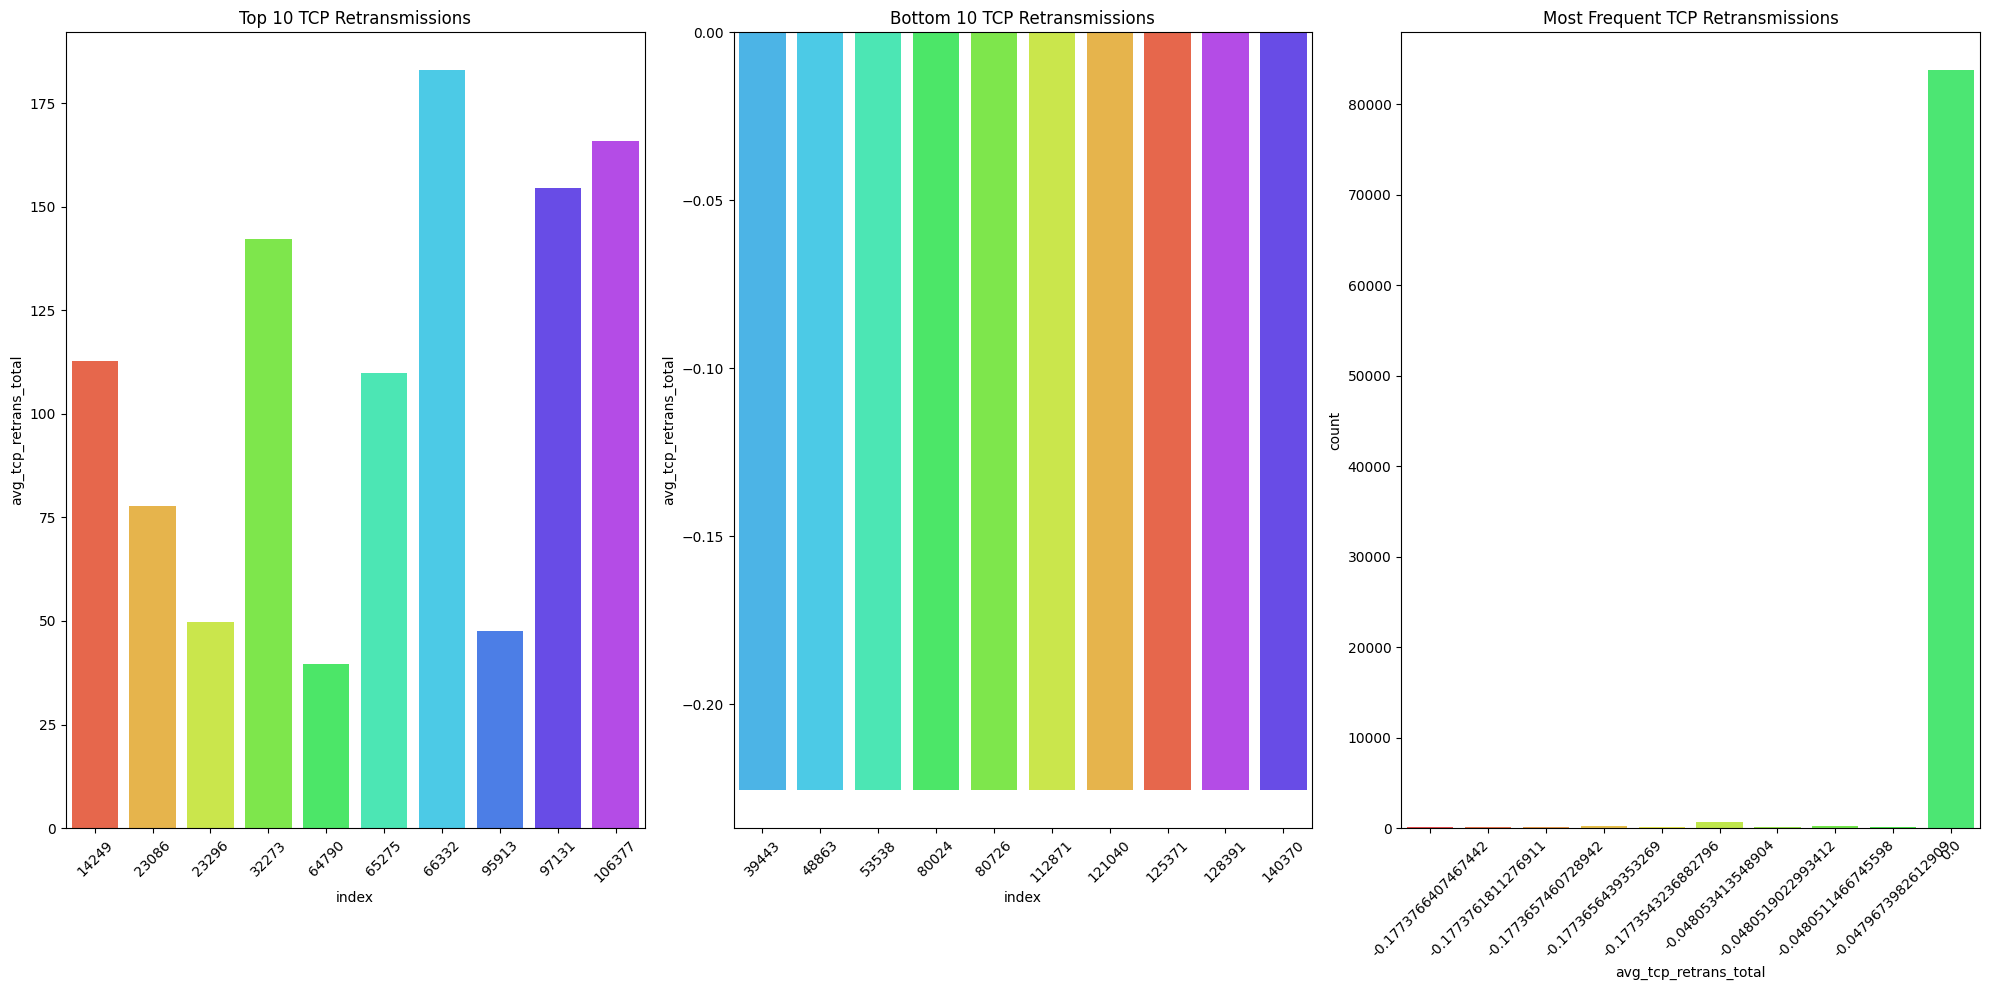

In [19]:
# Extract the top, bottom, and most frequent retransmission values
top_10_retrans = user_experience.nlargest(10, 'avg_tcp_retrans_total')[['avg_tcp_retrans_total']].reset_index()
bottom_10_retrans = user_experience.nsmallest(10, 'avg_tcp_retrans_total')[['avg_tcp_retrans_total']].reset_index()
most_frequent_retrans = user_experience['avg_tcp_retrans_total'].value_counts().nlargest(10).reset_index()
most_frequent_retrans.columns = ['avg_tcp_retrans_total', 'count']

# Define custom color palettes
custom_colors_top = ['#FF5733', '#FFBD33', '#DBFF33', '#75FF33', '#33FF57', '#33FFBD', '#33DBFF', '#3375FF', '#5733FF', '#BD33FF']
custom_colors_bottom = ['#33BDFF', '#33DBFF', '#33FFBD', '#33FF57', '#75FF33', '#DBFF33', '#FFBD33', '#FF5733', '#BD33FF', '#5733FF']
custom_colors_frequent = ['#FF3333', '#FF6633', '#FF9933', '#FFCC33', '#FFFF33', '#CCFF33', '#99FF33', '#66FF33', '#33FF33', '#33FF66']

# Create the figure with 3 subplots
f, axes = plt.subplots(1, 3, figsize=(20, 10))

# First bar plot for top_10_retrans with custom color
ax1 = sns.barplot(x=top_10_retrans['index'], y=top_10_retrans['avg_tcp_retrans_total'], ax=axes[0], palette=custom_colors_top)
ax1.set_title("Top 10 TCP Retransmissions")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Second bar plot for bottom_10_retrans with custom color
ax2 = sns.barplot(x=bottom_10_retrans['index'], y=bottom_10_retrans['avg_tcp_retrans_total'], ax=axes[1], palette=custom_colors_bottom)
ax2.set_title("Bottom 10 TCP Retransmissions")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Third bar plot for most_frequent_retrans with custom color
ax3 = sns.barplot(x=most_frequent_retrans['avg_tcp_retrans_total'], y=most_frequent_retrans['count'], ax=axes[2], palette=custom_colors_frequent)
ax3.set_title("Most Frequent TCP Retransmissions")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Distribution of the average throughput per handset

In [20]:
user_experience.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP UL (Bytes/s),Avg Bearer TP DL (Bytes/s),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Handset Type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,-0.002510,-0.135939,-1.645883e-01,-0.373847,-0.556274,0.000000,0.000000,Apple iPhone 7 (A1778),-3.005272e-01,-0.930121,0.000000
1,-0.002509,0.000000,4.613194e-17,-0.382889,-0.557894,0.000000,0.000000,Samsung Galaxy J5 (Sm-J530),4.613194e-17,-0.940783,0.000000
2,-0.002636,-0.039100,1.720148e-02,1.448078,0.586901,-0.079805,0.026181,Huawei B528S-23A,-2.189841e-02,2.034979,-0.053624
3,-0.002506,-0.072621,7.313758e-01,0.193850,0.194945,-0.174039,-0.008035,Huawei B528S-23A,6.587547e-01,0.388794,-0.182074
4,-0.002624,0.000000,4.613194e-17,-0.375354,-0.557188,0.000000,0.000000,Samsung Galaxy S8 (Sm-G950F),4.613194e-17,-0.932542,0.000000


In [21]:
handset_type_df = user_experience.groupby('Handset Type').agg(
    {'avg_bearer_tp_total': 'mean', 'avg_tcp_retrans_total': 'mean'})
handset_type_df.head()

,avg_bearer_tp_total,avg_tcp_retrans_total
Handset Type,,
A-Link Telecom I. Cubot A5,0.090340,0.000000
A-Link Telecom I. Cubot Note Plus,-0.634791,-0.219512
A-Link Telecom I. Cubot Note S,-0.498384,0.130625
A-Link Telecom I. Cubot Nova,1.487998,-0.224272
A-Link Telecom I. Cubot Power,2.002344,-0.225430


Top throughput

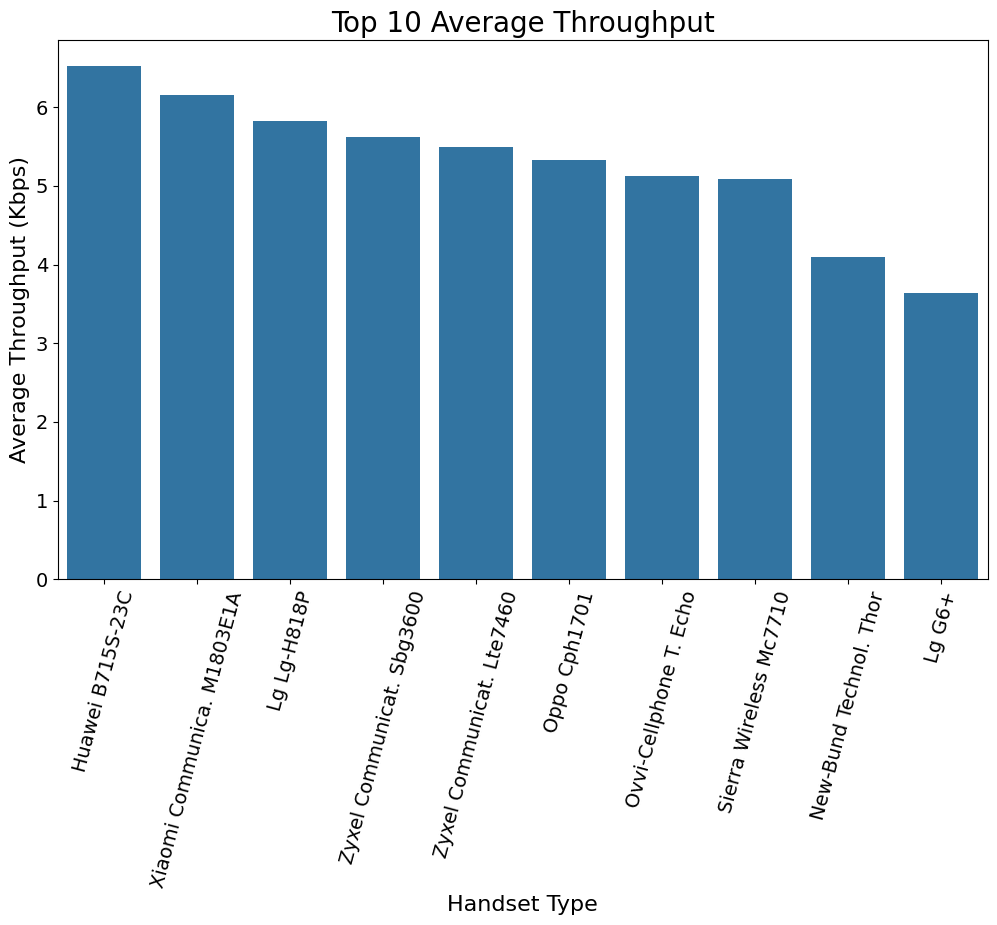

In [22]:
top_tp = handset_type_df.nlargest(10, 'avg_bearer_tp_total')
pl.plot_bar(top_tp ,top_tp.index, top_tp.avg_bearer_tp_total, "Top 10 Average Throughput", "Handset Type", "Average Throughput (Kbps)")

The average TCP retransmission view per handset type and provide interpretation for your findings.

Top TCP retransmission

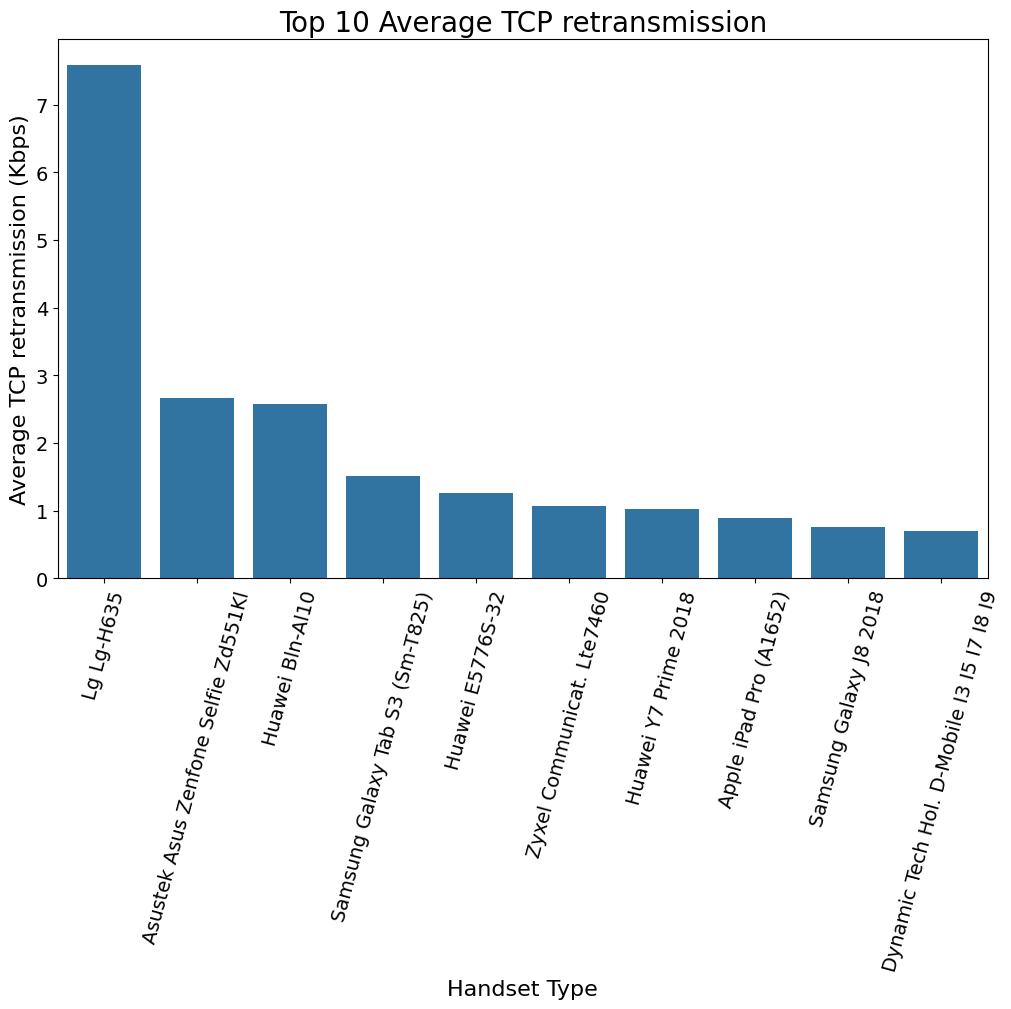

In [23]:
top_tcp = handset_type_df.nlargest(10, 'avg_tcp_retrans_total')
pl.plot_bar(top_tcp ,top_tcp.index, top_tcp.avg_tcp_retrans_total, "Top 10 Average TCP retransmission", "Handset Type", "Average TCP retransmission (Kbps)")

Using the experience metrics above, perform a k-means clustering (where k = 3) to segment users into groups of experiences and provide a brief description of each cluster. (The description must define each group based on your understanding of the data)

In [24]:
user_experience_df.head(5)

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,Handset Type
MSISDN/Number,,,,
-0.002692,-3.449670e-01,-0.933036,0.000000,Huawei P20 Lite Huawei Nova 3E
-0.002692,-3.617786e-01,-0.929996,0.000000,Apple iPhone 7 (A1778)
-0.002692,4.613194e-17,-0.930427,0.000000,undefined
-0.002692,-1.073595e-01,-0.925022,-0.177368,Apple iPhone 5S (A1457)
-0.002692,-5.840387e-01,3.333343,-0.144598,Apple iPhone Se (A1723)


In [25]:
# Drop the handset_type column
user_experience = user_experience_df.drop(['Handset Type'], axis=1)

In [26]:
user_experience.isnull().sum()

avg_rtt_total          0
avg_tp_total           0
total_avg_tcp_total    0
dtype: int64

In [27]:
def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data 
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Function to normalize specific columns in a DataFrame
def normalizer(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

# List of columns to normalize
columns_to_normalize = ['avg_rtt_total', 'avg_tp_total', 'total_avg_tcp_total']

# Applying the normalizer function
normalized_user_experience = normalizer(user_experience, columns_to_normalize)

# Display normalized data
normalized_user_experience.head()

,avg_rtt_total,avg_tp_total,total_avg_tcp_total
MSISDN/Number,,,
-0.002692,0.024925,0.055505,0.103643
-0.002692,0.024834,0.055524,0.103643
-0.002692,0.026789,0.055522,0.103643
-0.002692,0.026209,0.055555,0.103153
-0.002692,0.023633,0.081818,0.103244


In [29]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized_user_experience)
centroids = kmeans.cluster_centers_

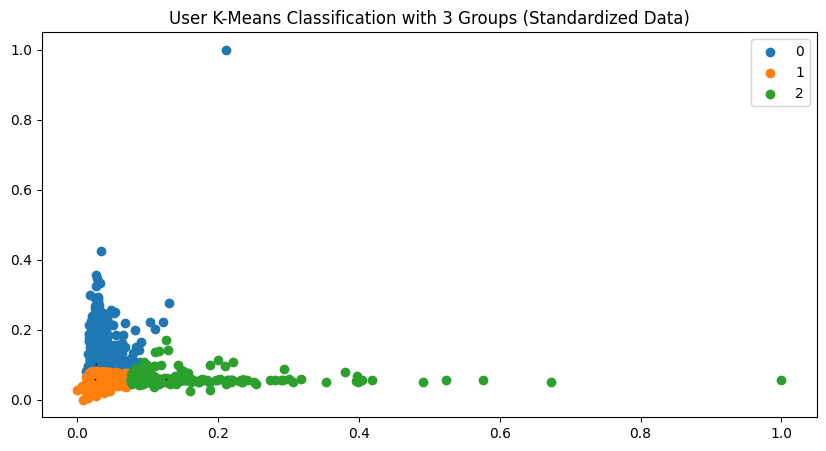

In [30]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized_user_experience[label == i].iloc[:,0] , normalized_user_experience[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

In [31]:
logger.info(f'# Centroids of the clustering:\n{centroids}')
logger.info(f'# The number of iterations required to converge: {kmeans.inertia_}')
logger.info(f'# The number of iterations required to converge: {kmeans.n_iter_}')

Add cluster group to the dataframe

In [32]:
u_exp = user_experience.copy()
u_exp.insert(0, 'cluster', kmeans.labels_)
u_exp.head(5)

,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total
MSISDN/Number,,,,
-0.002692,1,0.024925,0.055505,0.103643
-0.002692,1,0.024834,0.055524,0.103643
-0.002692,1,0.026789,0.055522,0.103643
-0.002692,1,0.026209,0.055555,0.103153
-0.002692,0,0.023633,0.081818,0.103244


Clusters overview

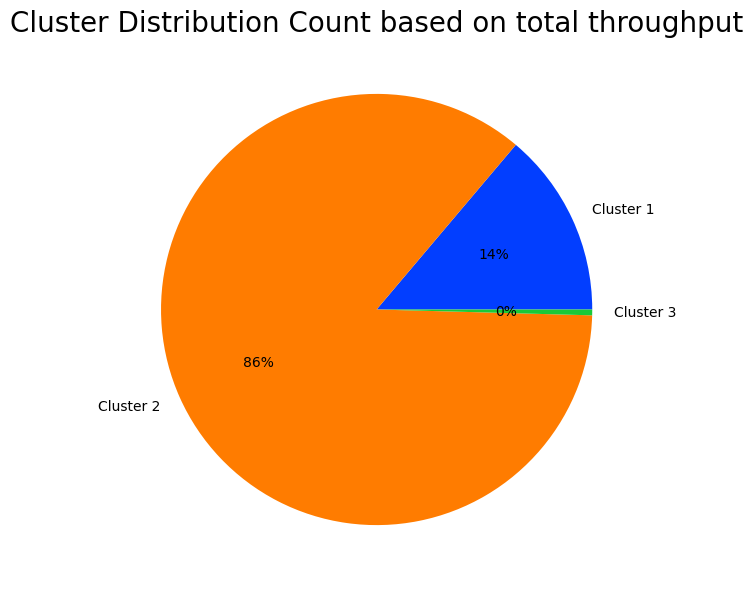

In [33]:
cluster1 = u_exp[u_exp["cluster"]==0]
cluster2 = u_exp[u_exp["cluster"] == 1]
cluster3 = u_exp[u_exp["cluster"] == 2]
data = [cluster1.avg_tp_total.sum(), cluster2.avg_tp_total.sum(), cluster3.avg_tp_total.sum()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# define Seaborn color palette to use
pl.plot_pie(data, keys, "Cluster Distribution Count based on total throughput")

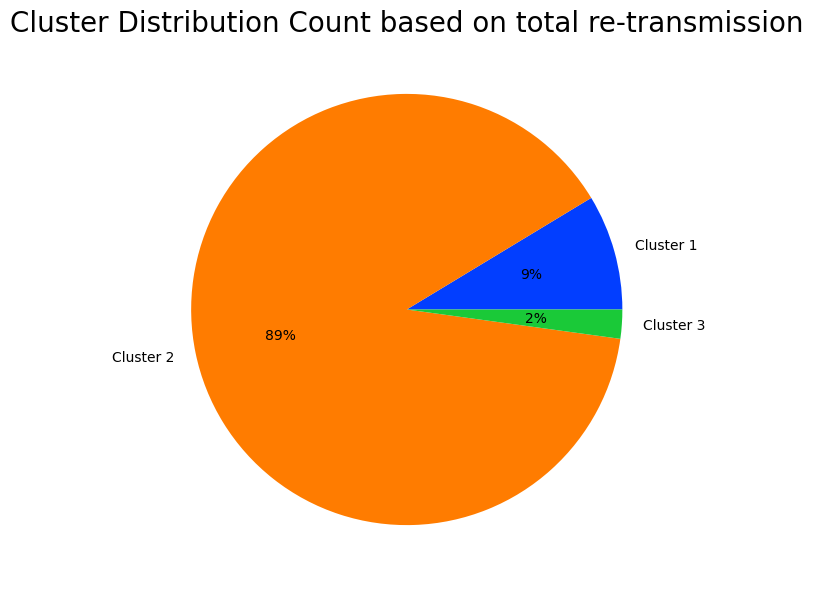

In [34]:
data = [cluster1.avg_rtt_total.sum(), cluster2.avg_rtt_total.sum(), cluster3.avg_rtt_total.sum()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# define Seaborn color palette to use
pl.plot_pie(data, keys, "Cluster Distribution Count based on total re-transmission")

Save the data

In [35]:
with open("../models/user_exp.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [36]:
user_experience.to_csv('../data/user_experience.csv')

In [37]:
u_exp.to_csv('../data/user_exp.csv')